In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../') # add the root folder to the path

from diffusion_model.backward_module import BackwardModule
from diffusion_model.forward_module import ForwardModule
from diffusion_model.embeddings import MLPEmbedding, LinearEmbedding
from diffusion_model.scheduler import Scheduler
from diffusion_model.models import UNetNoiseModel
from diffusion_model.datasets import get_mnist_dataset
from diffusion_model.constants import device

import numpy as np
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from einops import rearrange

import matplotlib.pyplot as plt
import matplotlib

In [3]:
FIG_SIZE = 4
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Datasets

Dataset shape: torch.Size([1000, 28, 28])


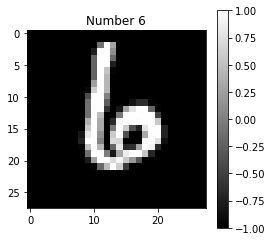

In [4]:
N_SAMPLES = 1000

dataset, labels = get_mnist_dataset(N_SAMPLES)
dim = tuple(dataset[0].shape)
flattened_dim = np.prod(dim)

plt.imshow(dataset[0].cpu(), cmap="gray")
plt.title(f"Number {labels[0]}")
plt.colorbar();
print(f"Dataset shape: {dataset.shape}")

In [5]:
print(f"Using device: {device}")

Using device: cuda


# Plot helpers

In [6]:
def plot_evolutions(xs_t, y_title=None, title=None):
    fig, axes = plt.subplots(1, len(xs_t), figsize=(FIG_SIZE*len(xs_t), FIG_SIZE))
    if title is not None:
        fig.suptitle(title)
    if y_title is not None:
        axes[0].set_ylabel(y_title)
    for i, ax in enumerate(axes):
        progress = i / (len(xs_t)-1)
        ax.imshow(xs_t[i].cpu(), cmap='gray')
        ax.set_title(f"{progress*100:.0f}%")
    plt.show()

# Embeddings

In [12]:
def check_embedding(base, embedding_model):
    with torch.no_grad():
        base = base.to(device)
        embedded_base = embedding_model(base).detach().cpu()
    for v in embedded_base:
        assert ((-1 <= v) & (v <= 1)).all(), "Embedding should be in [-1, 1]"

    n = len(base)
    dist_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = torch.norm(embedded_base[i] - embedded_base[j])
    plt.title("Distance matrix")
    plt.imshow(dist_matrix, cmap='gray')
    plt.colorbar()

## Label embedding

100%|██████████| 1000/1000 [00:11<00:00, 86.62it/s]


Loss: 1.906242641780409e-05


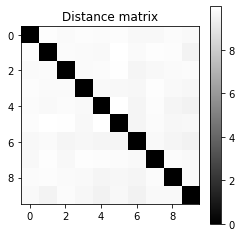

In [13]:
label_embedding = MLPEmbedding(10, flattened_dim)

labels_one_hot = F.one_hot(labels, 10).float()
label_dataloader = DataLoader(labels_one_hot, batch_size=256, shuffle=True)
loss = label_embedding.fit(label_dataloader, nb_epochs=1000)
print(f"Loss: {loss}")

check_embedding(torch.eye(10), label_embedding)

## Time steps embedding

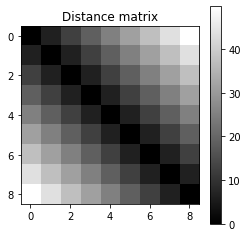

In [14]:
T = 10

time_embedding = LinearEmbedding(flattened_dim, 0, T-1)

check_embedding(torch.arange(0, T-1), time_embedding)

# Diffusion model

## Scheduler

In [19]:
scheduler = Scheduler(input_dim=dim, nb_steps=T)

assert len(scheduler.betas) == T+1

AssertionError: 

In [15]:
scheduler = Scheduler(input_dim=dim, nb_steps=T)
forward_module = ForwardModule(scheduler=scheduler)
noise_model = UNetNoiseModel(forward_module=forward_module, scheduler=scheduler, time_embedding=time_embedding, label_embedding=label_embedding)
backward_module = BackwardModule(forward_module=forward_module, scheduler=scheduler, noise_model=noise_model)

## Forward

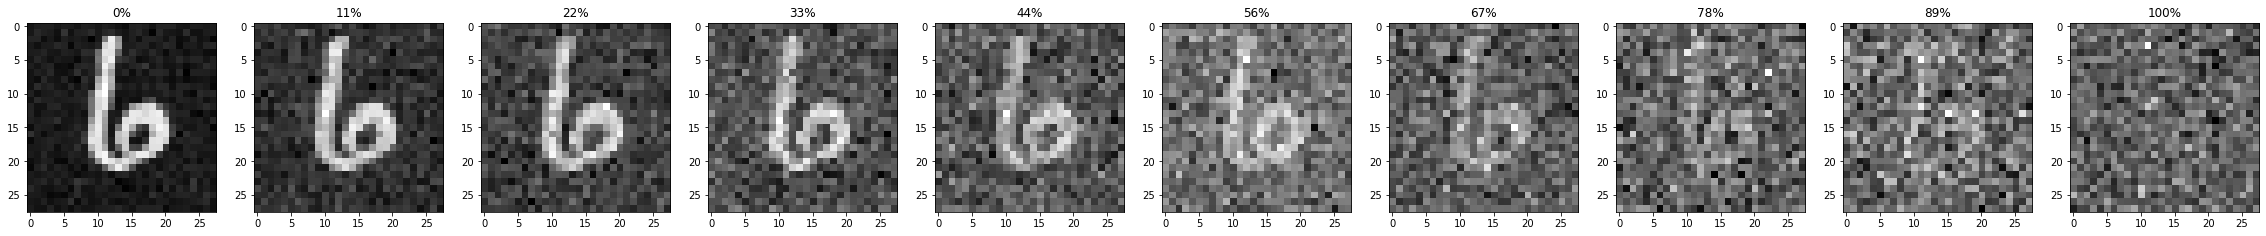

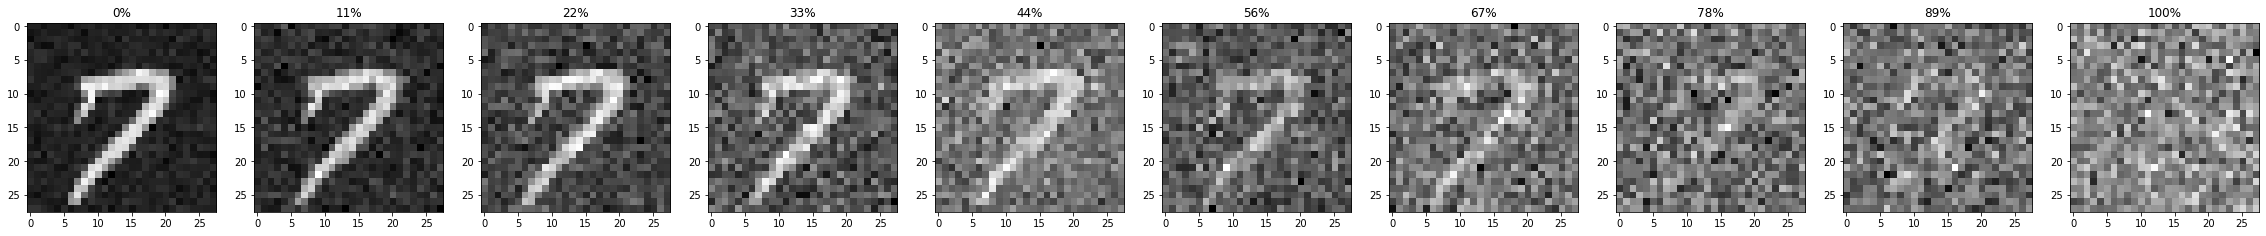

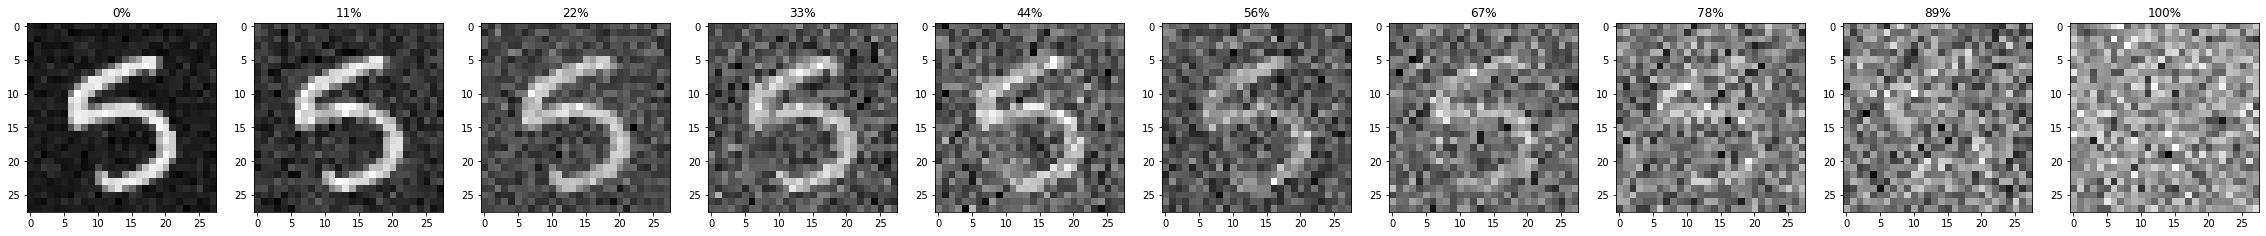

In [16]:
NB_DISPLAYED = 10
NB_EXAMPLES = 3

xs = dataset[:NB_EXAMPLES]
xs = forward_module.loop_forward(xs, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for x in xs:
    plot_evolutions(x)

## Train the noise model

  0%|          | 0/100 [00:00<?, ?it/s]

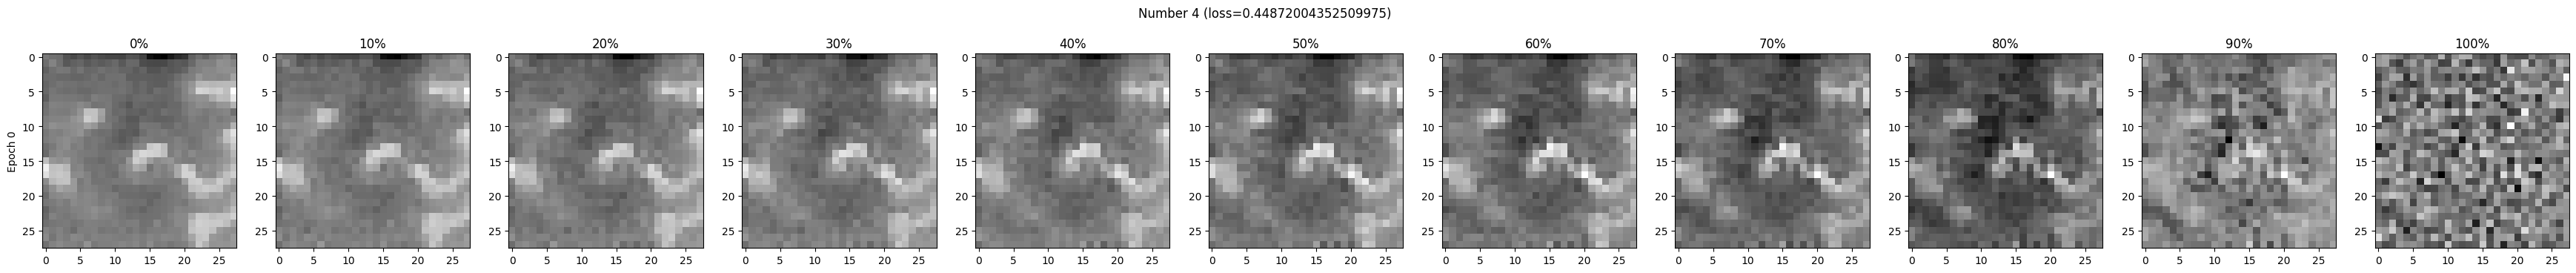

 10%|█         | 10/100 [00:59<08:48,  5.87s/it]

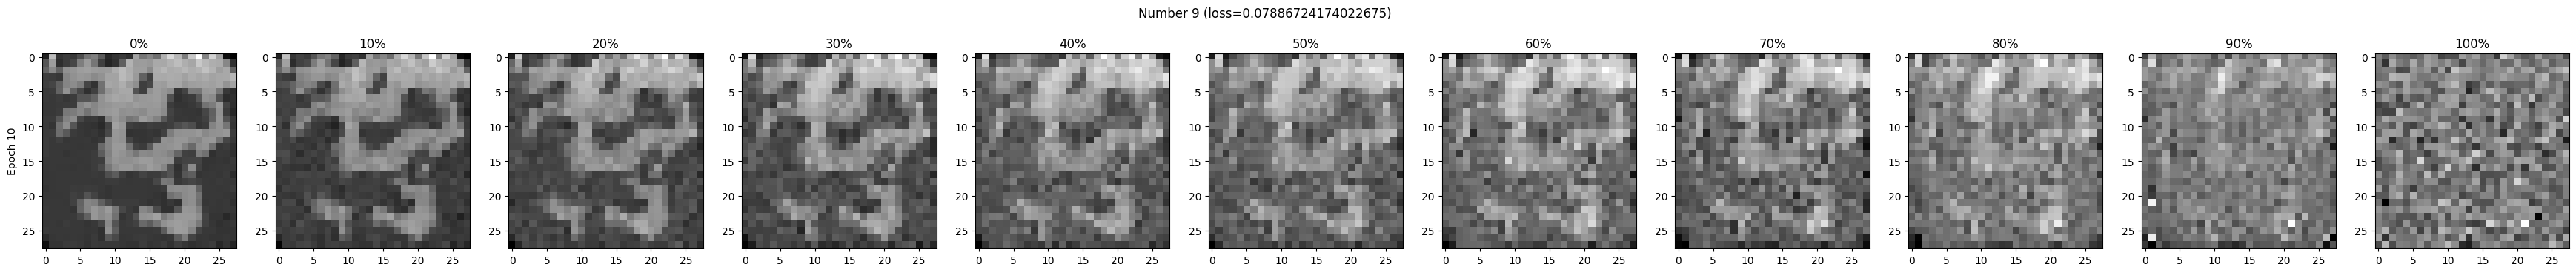

 20%|██        | 20/100 [01:58<07:53,  5.91s/it]

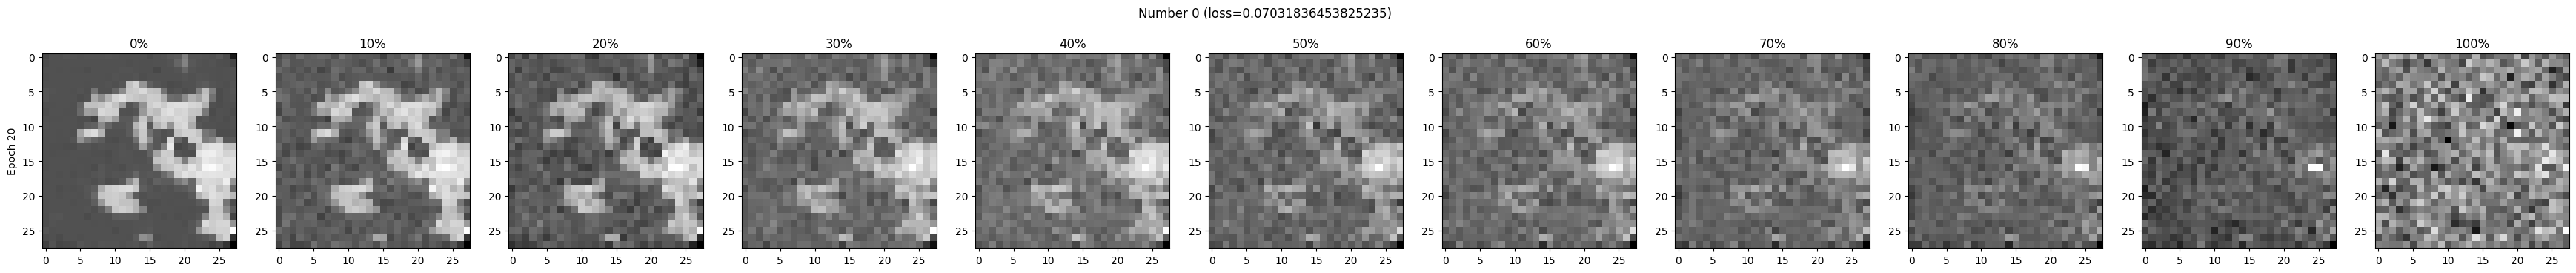

 30%|███       | 30/100 [02:58<06:56,  5.95s/it]

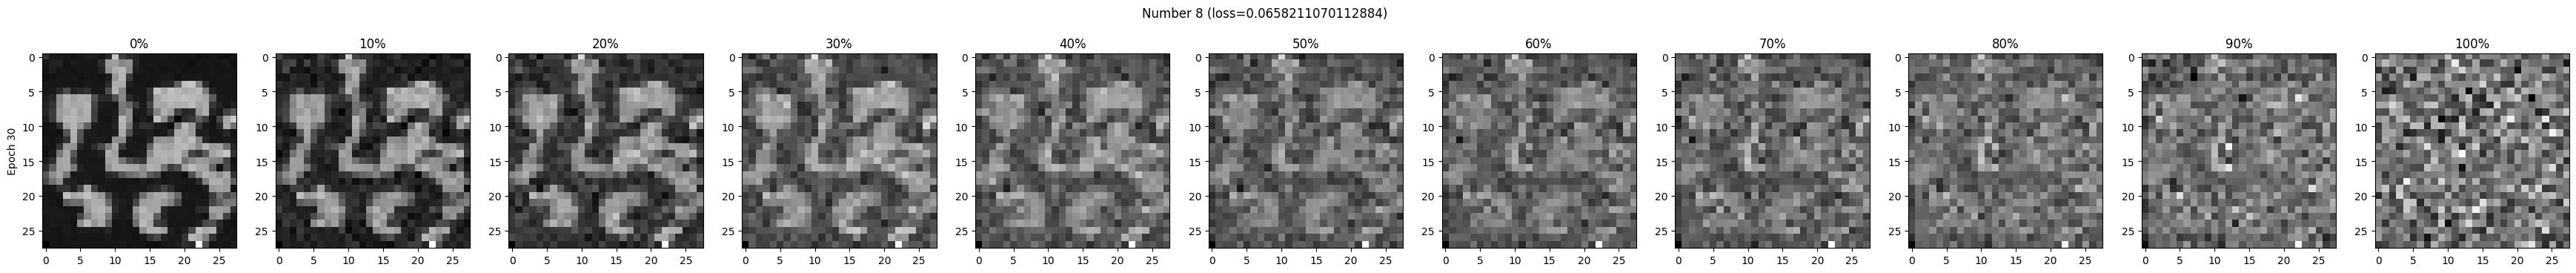

 40%|████      | 40/100 [03:58<05:54,  5.90s/it]

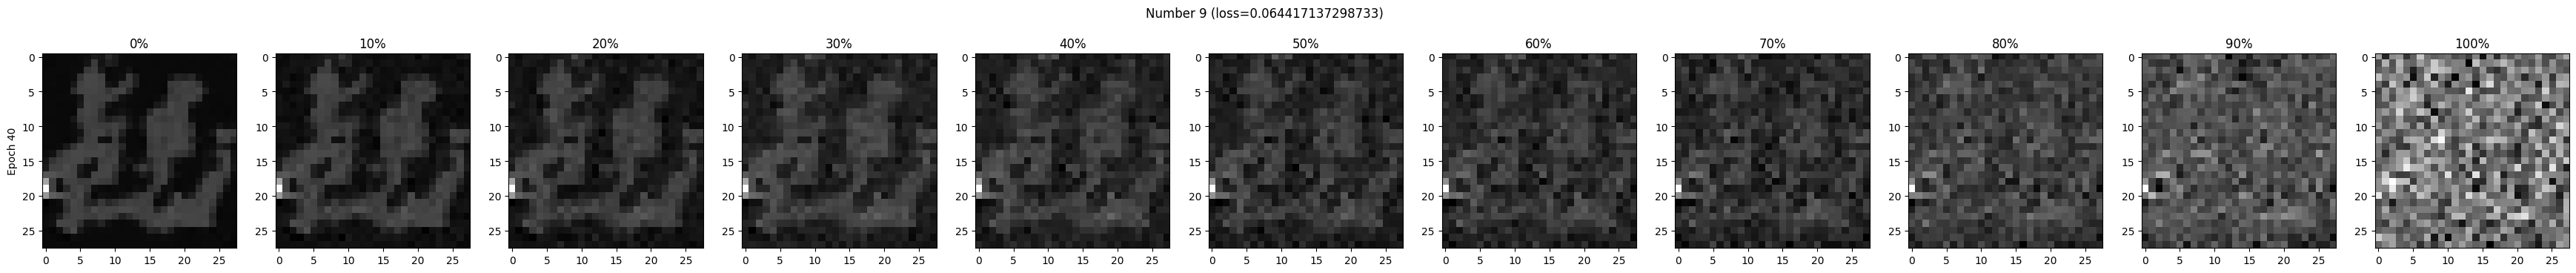

 50%|█████     | 50/100 [04:58<04:55,  5.91s/it]

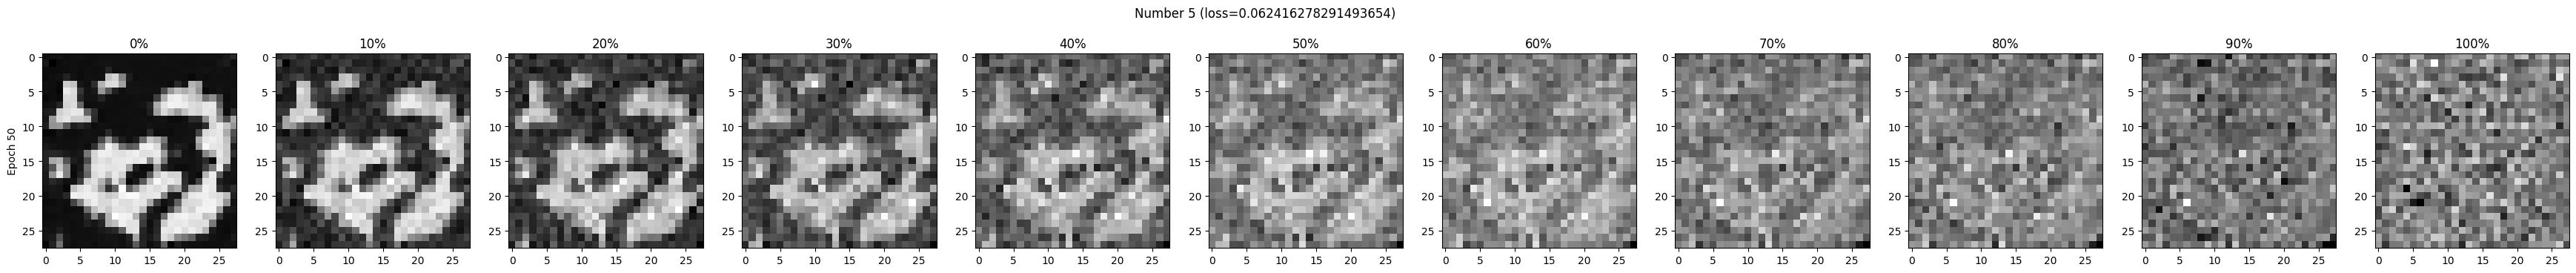

 60%|██████    | 60/100 [05:57<03:56,  5.91s/it]

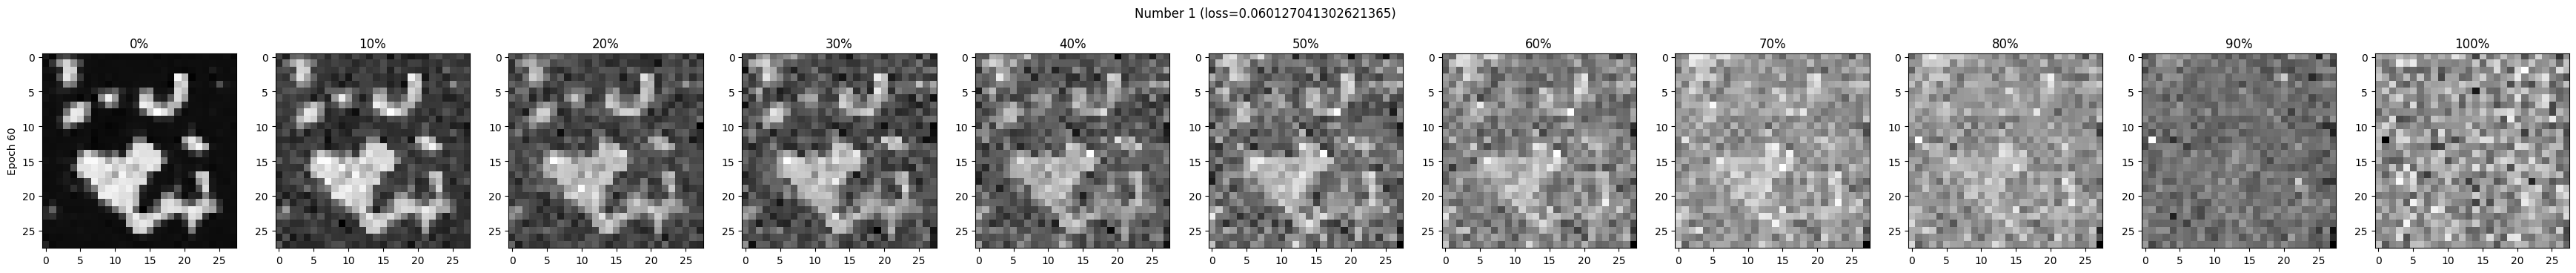

 70%|███████   | 70/100 [07:02<03:00,  6.03s/it]


KeyboardInterrupt: 

In [58]:
BATCH_SIZE = 128
NB_EPOCHS = 100

def random_label():
    label_idx = torch.randint(0, 10, (1,)).item()
    label_vec = torch.eye(10)[label_idx].float()
    label_vec = rearrange(label_vec, "d -> 1 d")
    return label_idx, label_vec

def display_evolutions(epoch, losses=None):
    loss = sum(losses) / len(losses) if losses else None
    label_idx, label_vec = random_label()
    xs_t = backward_module.loop_backward(label_vec, n_sample=1, nb_displayed_steps=NB_DISPLAYED)
    x_t = rearrange(xs_t, "t 1 h w -> t h w")
    plot_evolutions(x_t, title=f"Number {label_idx} (loss={loss})", y_title=f"Epoch {epoch}")

X = TensorDataset(dataset, labels_one_hot)
dataloader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True)
noise_model.fit(dataloader, nb_epochs=NB_EPOCHS, logger=display_evolutions)
display_evolutions(NB_EPOCHS)

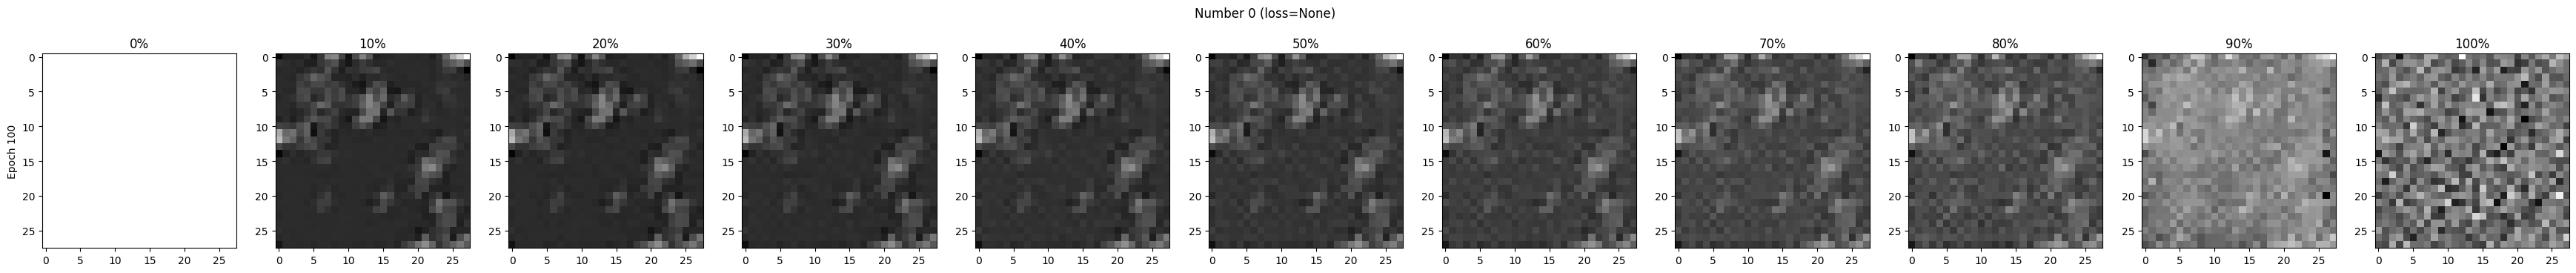

In [46]:
display_evolutions(NB_EPOCHS)

## Backward

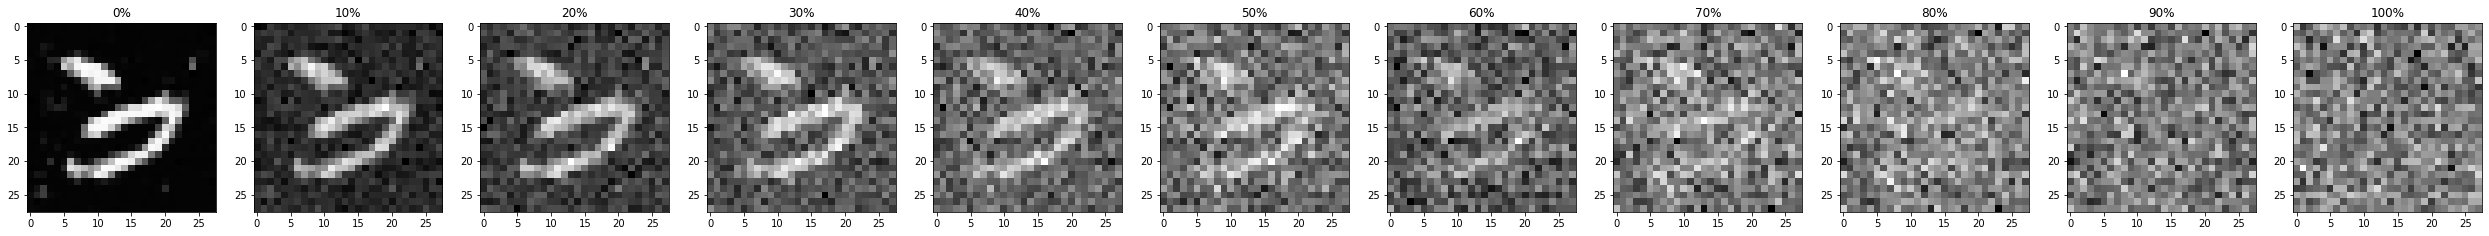

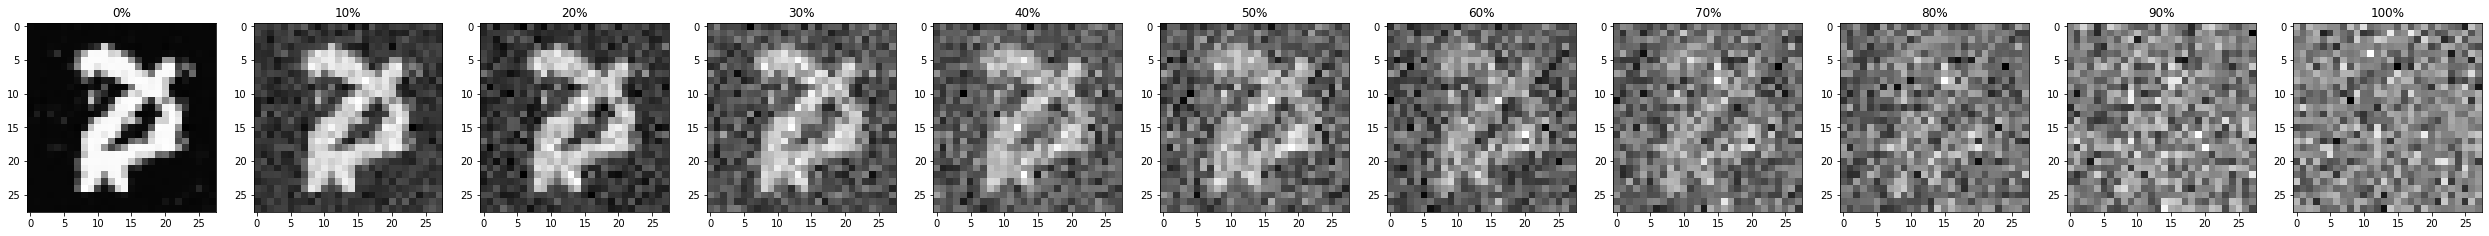

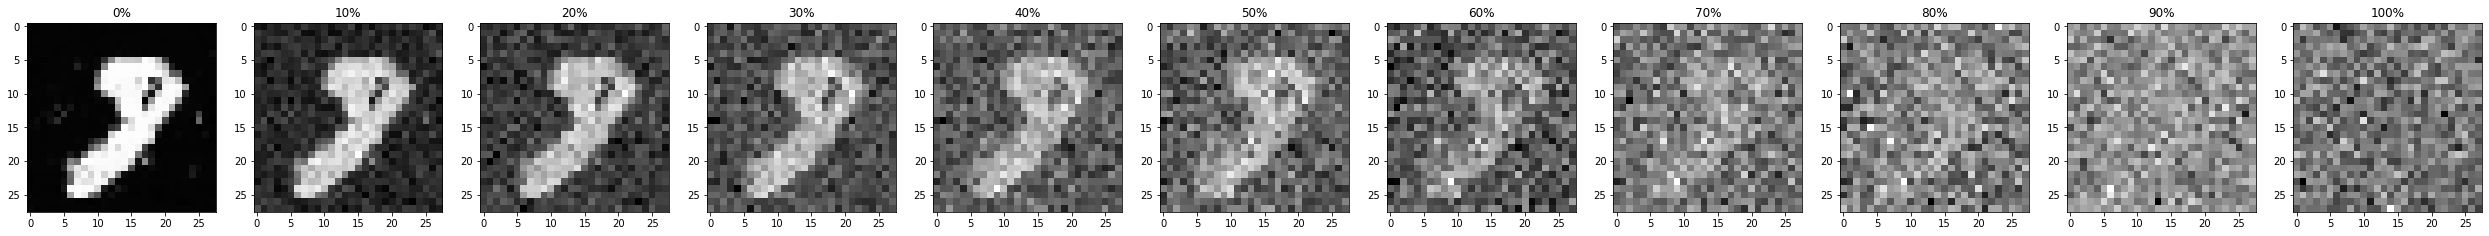

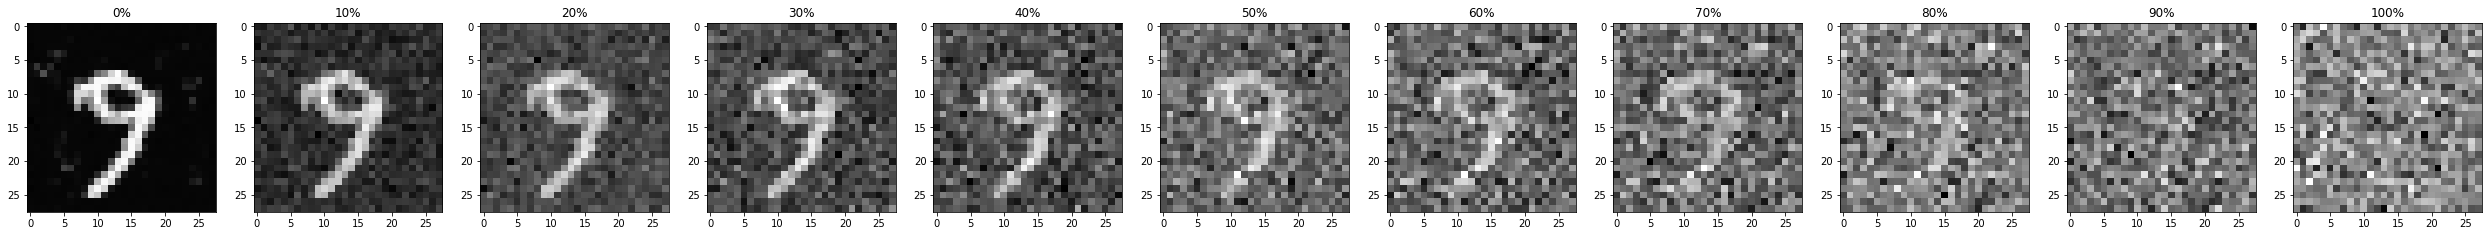

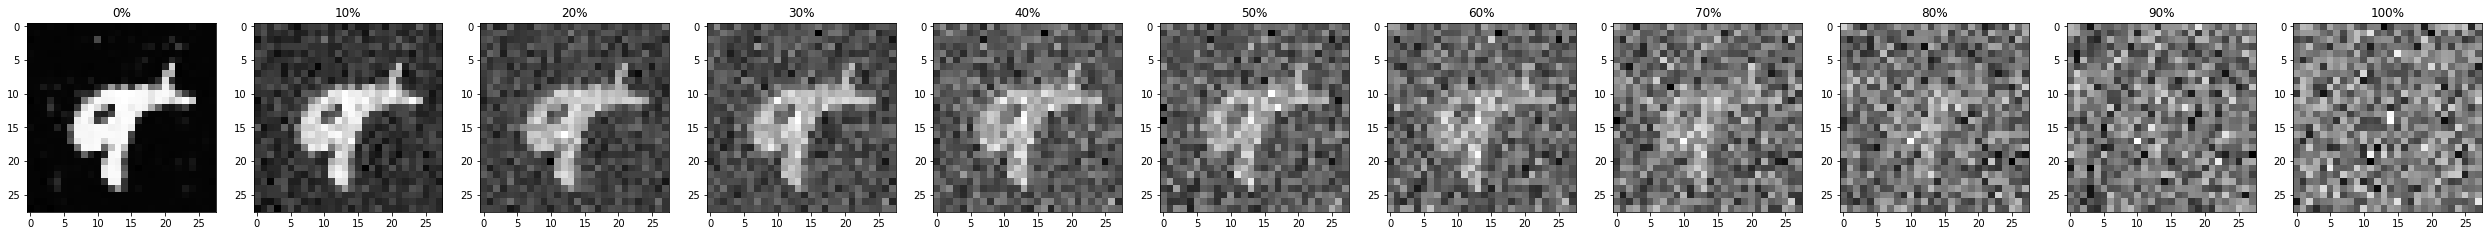

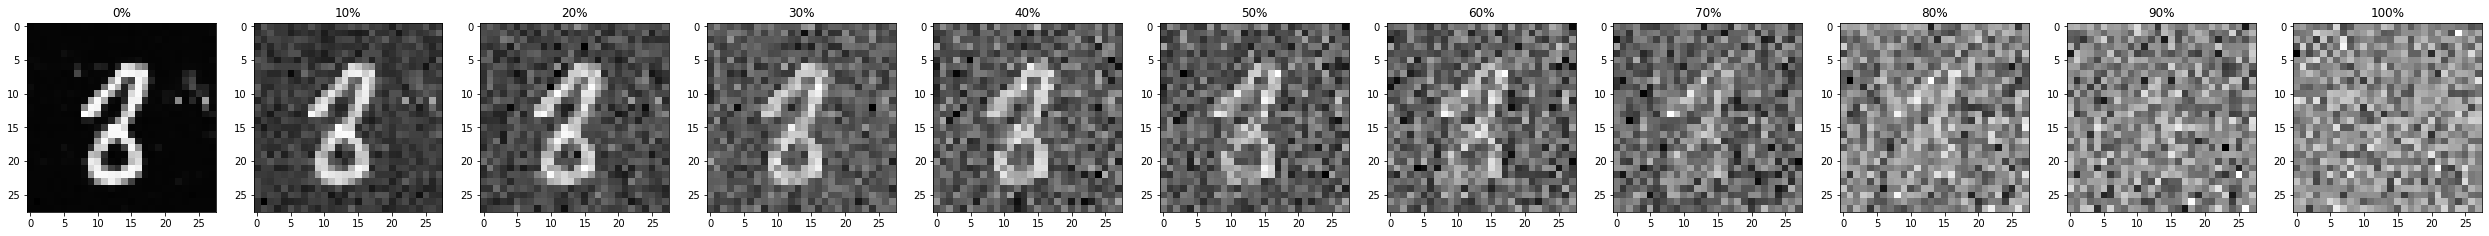

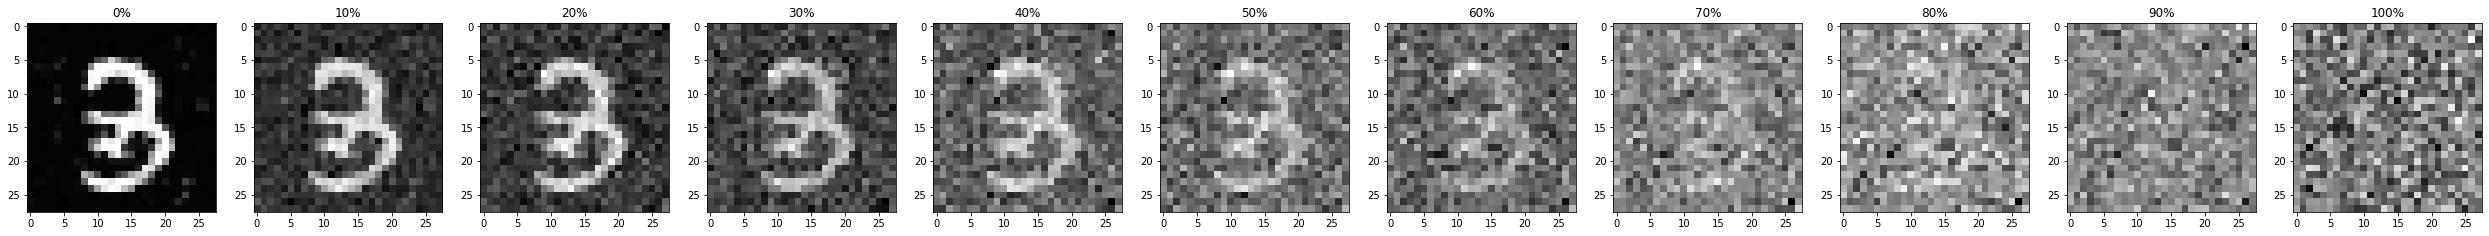

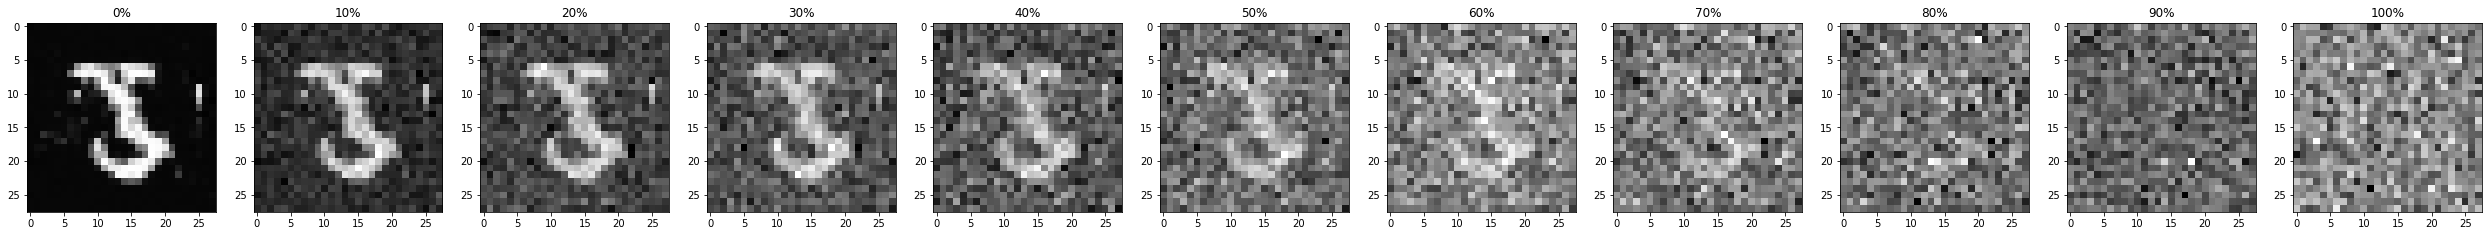

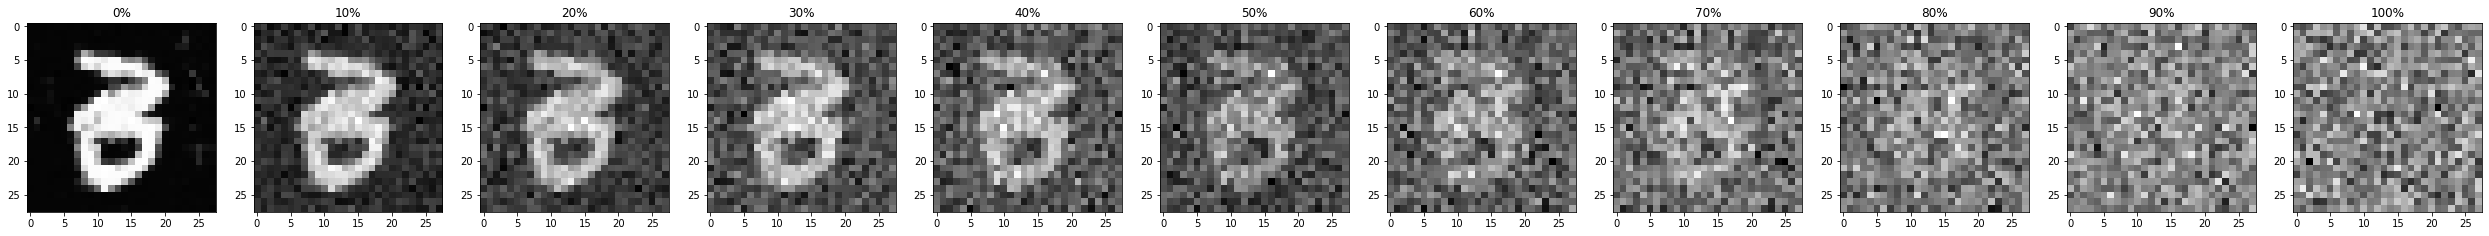

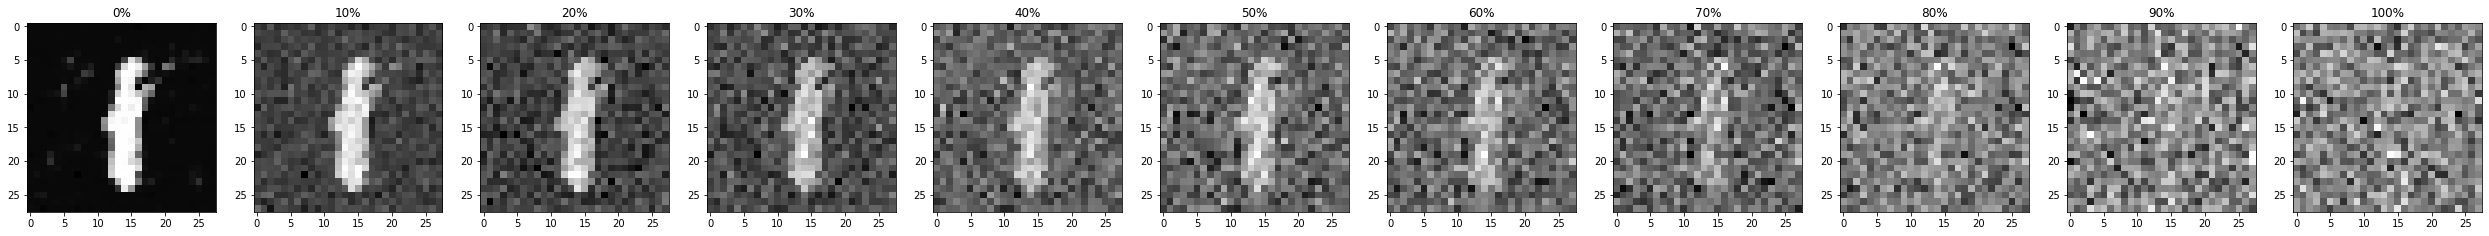

In [56]:
NB_EXAMPLES = 10

xs = backward_module.loop_backward(n_sample=NB_EXAMPLES, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for x in xs:
    plot_evolutions(x)